In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
seed_value = 42
data = pd.read_csv('/kaggle/input/spotify-dataset/DATASET.csv')
data.head()

/kaggle/input/spotify-dataset/DATASET.csv
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/saved_model.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/keras_metadata.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/assets/vocab.txt
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.index
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.data-00000-of-00001


,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


# Steps 1 & 2: Gather Data, Determine the method of data collection, and identify a Deep Learning problem

Our data source is a csv of 51,000 reviews of the Spotify application, scrapped from the Google  Play store between January and July 2022. The dataset initially has two features - 'Review' the review text, and label ('POSITIVE' or 'NEGATIVE').

We will be using deep learning architectures for sentiment analysis - correctly classifying reviews as positive or negative. 

# Step 3: EDA - Inspect, Visualize, and Clean the Data

For starters, **we'll convert POSITIVE to 1 and NEGATIVE to 0.** Then, we'll split the data into train and test sets.

In [2]:
data['label'] = data['label'].replace({'POSITIVE':1, 'NEGATIVE':0})
data['label'] = data['label'].astype(np.float32)

/tmp/ipykernel_17/4036339173.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['label'] = data['label'].replace({'POSITIVE':1, 'NEGATIVE':0})


Let's inspect our Review column a little more closely, and ensure we don't have any invalid formats.

In [3]:
type_counts = Counter(data['Review'].apply(lambda x: type(x).__name__))

for value_type, count in type_counts.items():
    print(f"{value_type}: {count}")

str: 52686
float: 16


Apparently we have 16 'float' values under Review text. 

In [4]:
# Filter rows where 'Review' column is of type float
float_reviews = data[data['Review'].apply(lambda x: isinstance(x, float))]

print(float_reviews)

      Review  label
49679    NaN    1.0
49690    NaN    1.0
49747    NaN    1.0
50005    NaN    1.0
50397    NaN    1.0
50437    NaN    1.0
50802    NaN    1.0
50883    NaN    1.0
50972    NaN    1.0
50973    NaN    1.0
51052    NaN    1.0
51295    NaN    1.0
51817    NaN    1.0
51841    NaN    1.0
52211    NaN    1.0
52218    NaN    1.0


These 16 reviews have NaN as their value. We'll remove these values. Even if they are true positive reviews, we want to develop a model on language. We also have significant reviews with less than 4 characters (73). We'll remove those too.

In [5]:
count_less_than_4 = (data['Review'].str.len() < 4).sum()
print(f"Number of reviews with less than 4 characters: {count_less_than_4}")

Number of reviews with less than 4 characters: 73


In [6]:
data = data[data['Review'].str.len() >= 4]

data = data.dropna(subset=['Review'])
label_counts = data['label'].value_counts()
print(label_counts)

label
0.0    29423
1.0    23190
Name: count, dtype: int64


The data is somewhat balanced, 56% negative and 44% positive. With binary classification, we really want to ensure we look at all metrics, not just accuracy (we don't want to train the model that a 0 is just more likely to be the answer). So, we will randomly remove negative reviews to have equal distribution of positive and negative classes.

In [7]:
data = data.drop(index=data[data['label'] ==0].sample(n=6160, random_state=seed_value).index)
label_counts = data['label'].value_counts()
print(label_counts)



X = data[['Review']]
y = data[['label']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

X_train_np = X_train.to_numpy().flatten()  
y_train_np = y_train.to_numpy().flatten() 

type_counts = Counter(type(x) for x in X_train_np)

print(type_counts)
X_test_np = X_test.to_numpy().flatten()  
y_test_np = y_test.to_numpy().flatten() 

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_np, y_test_np))
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)


review_lengths = data['Review'].str.len()

max_length = review_lengths.max()

print("The longest review length is:", max_length)

word_counts = data['Review'].str.split().str.len()

max_word_count = word_counts.max()

print("Max word count is:",max_word_count)

label
0.0    23263
1.0    23190
Name: count, dtype: int64
Counter({<class 'str'>: 37162})
The longest review length is: 1693
Max word count is: 423


The next step in our data cleaning will be encoding our data into text vectors. This will involve removing all punctuation and converting to lower case.

In [8]:
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt

encoder = TextVectorization(
    max_tokens=5000,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=425,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
    name=None
)
encoder.adapt(train_dataset.map(lambda text, Review: text))

vocabulary = encoder.get_vocabulary()

Let's look at some visualizations. We'll look at our token frequency. When our encoder learns the vocabulary, it has a maximum number of tokens to assigned. For words deemed to have significant enough meaning to make it into the vocabulary, they are assigned a unique token. We will analyze what the frequency of our tokens are, once created.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


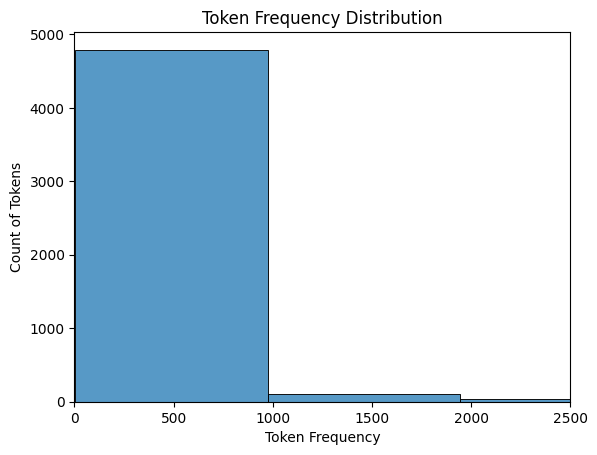

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

encoded_data = encoder(X)

token_indices = np.concatenate(encoded_data)

token_indices = token_indices[token_indices != 0]

unique_tokens, token_counts = np.unique(token_indices, return_counts=True)

sns.histplot(token_counts, bins=50)
plt.title("Token Frequency Distribution")
plt.xlabel("Token Frequency")
plt.ylabel("Count of Tokens")
plt.xlim(0, 2500)
plt.show()


It definitely seems like the most impactful tokens are just over 7000 in number. This may be an impactful insight as we tweak model hyperparameters, such as max_vocabulary.

Let's look at our padding ratio. Our encoder will map our reviews into vectors. To ensure uniform length for our model to process, we use padding - 0's added to the beginning or end of the string that are not used by our model for learning purposes. Our longest review is 423 words (rounded to 425), so anything with fewer words, will have padding. We can look at what the  distribution of ratios is for our padding.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


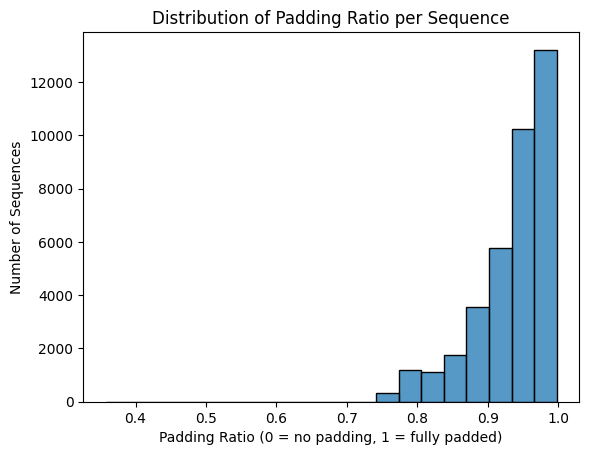

In [10]:

def calculate_padding_ratio(sequence):
    return (sequence == 0).sum() / len(sequence)

padded_ratios = []
c = 0
for batch in train_dataset:
   
    texts, _ = batch  
    
    encoded_texts = encoder(texts)
    
    for seq in encoded_texts.numpy(): 
        d = 1
        padded_ratios.append(calculate_padding_ratio(seq))

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(padded_ratios, bins=20)
plt.title("Distribution of Padding Ratio per Sequence")
plt.xlabel("Padding Ratio (0 = no padding, 1 = fully padded)")
plt.ylabel("Number of Sequences")

plt.show()


It seems like we are leveraging padding quite heavily, possibly based on a relatively small number of reviews. It shouldn't affect our key model metrics, but may make it less performant in terms of speed. We will leave the data alone for now.

Let's visualize a word cloud of the most commonly used words.

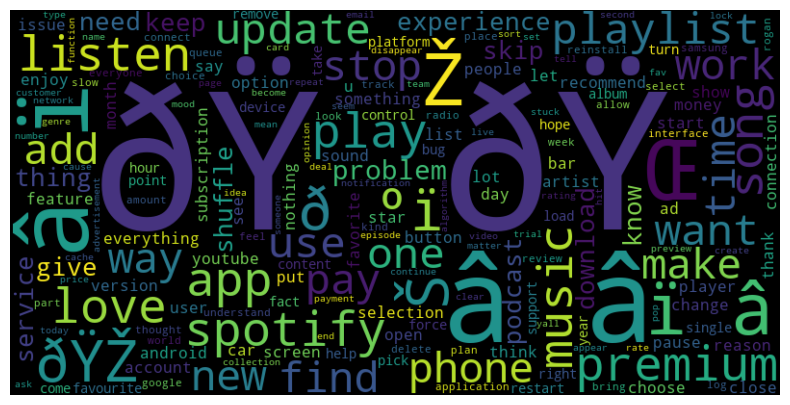

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400).generate(" ".join(vocabulary))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Interesting to see some sentiment visualization. We see some clearly positive sentiment in fairly large emphasis, such as "favorite," "love," but there are some annoyed-sounding words in there as well. "Please","restart", "hate", etc. There are some unknown characters (ðŸ ðŸ) in the mix, however there is a chance they could be special characters or emojis. We'll take a closer look at some of these top-occuring strings.

In [12]:

word_frequencies = wordcloud.process_text(" ".join(vocabulary))

top_words = sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:20]

print("Top 20 Most Frequent Words:")
for word, freq in top_words:
    print(f"{word}: {freq}")

Top 20 Most Frequent Words:
ðŸ ðŸ: 66
â â: 15
â ï: 10
Œ: 7
Ž: 5
ï â: 5
ðŸŽ: 3
Š: 3
ºï: 3
ð: 3
app: 2
music: 2
spotify: 2
song: 2
play: 2
love: 2
listen: 2
premium: 2
playlist: 2
want: 2


Given the amount of data we have, the relatively low occurence of these special strings, and the chance that the strings could represent sentiment in a way that our text scraper was not able to convey, we will leave these in and see how our model performs.

# Step 4 Perform Analysis Using Deep Learning Models of Your Choice, Present Discussion, and Conclusions

We'll be contrasting a couple of different deep learning approaches, tweaking hyperparameters, and seeing where we get the best results. We'll look at Recurrent Neural Networks, as well as Bidirectional Encoder Representations from Transformers. Starting with RNN's. In our model architecture, we have an input layer (accepting one text string at a time), our encoder which will map each word to a token ID based on our vocabulary. The embedding layer will map these token ID's into a matrix, padding with 0's if necessary to length 64. Our bidirectional layer will "read" each string both forward and backward, to learn sequential contexts. Our dense layer provides a non-linear transformation to learn complex features, and our final linear activation layer yields our prediction.

We are using long short-term memory (LSTM) architecture as it is generally optimal for sequential data, albeit with longer training times.

Our loss function will be binary cross-entropy, which works well for binary classification, giving us the difference between the true label and the predicted probability the model outputs.

In [13]:
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=(1,),dtype=tf.string),
#     encoder,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder.get_vocabulary()),
#         output_dim=64,
#         mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(0.0001),
#               metrics=[
#         'accuracy',
#         tf.keras.metrics.AUC(),  
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall() 
#     ])

# history = model.fit(train_dataset, epochs=10)

# test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(test_dataset)

# print(f'Test Loss: {test_loss:.4f}')
# print(f'Test Accuracy: {test_accuracy:.4f}')
# print(f'Test AUC: {test_auc:.4f}')
# print(f'Test Precision: {test_precision:.4f}')
# print(f'Test Recall: {test_recall:.4f}')


We'll also take a look at an alternate neural network architecture for comparison. Our initial architecture was relatively simple. In this "Model B", we'll try adding an additional bidirectional layer to try to capture additional semantic context, as well as dropout layers. Dropout layers, or dropout regularization, involve randomly resetting a subset of neurons in the neural network, with the aim of preventing overfitting.

This will be an interesting test if a simpler or complex model will work better in capturing sentiment analysis. 

Also, a brief word on workflow. The instructor of this course encourages an iterative approach for hyperparameter tuning. This may work if we have unlimited processing time, GPU runtime, or very simple and small datasets. However, this is Kaggle, and we are using large datasets. An iterative workflow is simple to implement (in the past, I have commented out theoretical nested-for-loop implementations of hyperparameter tuning), however this has turned out to be redundant in practice, not completing within 12 hours. We will assume that you are familiar with these programming concepts, and input our hyperparameters directly for both models.

In [14]:
#model B

# modelB = tf.keras.Sequential([
#     tf.keras.Input(shape=(1,), dtype=tf.string),
#     encoder,
#     tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# modelB.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy',
#         tf.keras.metrics.AUC(),  
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()])

# history = modelB.fit(train_dataset, epochs=10)

# test_loss, test_accuracy, test_auc, test_precision, test_recall = modelB.evaluate(test_dataset)

# print(f'Test Loss: {test_loss:.4f}')
# print(f'Test Accuracy: {test_accuracy:.4f}')
# print(f'Test AUC: {test_auc:.4f}')
# print(f'Test Precision: {test_precision:.4f}')
# print(f'Test Recall: {test_recall:.4f}')


# Additional parameter fine-tuning for RNN here

We'll look at Bidirectional Encoder Representations from Transformers (BERT) next. Bidirectional implies that sentiment analysis can be performed both forwards and backwards. For a given word, BERT can make inferences based on the other vectors (words) to its left and right. BERT models use encoders, but not transformers, making them a bit unique amongst deep learning models used for NLP. 

BERT models are pre-trained using a massive corpus, which is achievable by large tech companies. We will be importing a BERT model, BERT-base to start, from the original creators. 

If you've worked with a BERT model previously, you'll notice they tend to have quite a long runtime. We will use a "small BERT" model which features less hyperparameters, and can reliably compute predictions within 12 hours.



In [15]:
from transformers import BertTokenizer, TFBertModel

# tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-4_H-256_A-4')
# bert_model = TFBertModel.from_pretrained("google/bert_uncased_L-4_H-256_A-4",from_pt=True)



In [16]:
from tensorflow.keras import layers, models
from transformers import AdamW

# max_length = 512

# train_encodings = tokenizer(
#         X_train['Review'].tolist(),
#         padding=True,
#         truncation=True,
#         max_length=max_length,
#         return_tensors='tf'
#     )
# test_encodings = tokenizer(
#         X_test['Review'].tolist(),
#         padding=True,
#         truncation=True,
#         max_length=max_length,
#         return_tensors='tf'
#     )

# train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_np)).batch(32)
# test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test_np)).batch(32)

# class BertClassifier(models.Model):
#     def __init__(self):
#         super(BertClassifier, self).__init__()
#         self.bert = bert_model
#         self.dropout = layers.Dropout(0.3)
#         self.dense = layers.Dense(1, activation='sigmoid')  # For binary classification

#     def call(self, inputs):
#         outputs = self.bert(inputs)
#         pooled_output = outputs[1]  # Take the pooled output
#         x = self.dropout(pooled_output)
#         return self.dense(x)


# model = BertClassifier()

# model.compile(optimizer='adam', 
#               loss='binary_crossentropy', 
#               metrics=['accuracy',
#              tf.keras.metrics.AUC(),  
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()])

# model.fit(train_dataset, epochs=10)

# results = model.evaluate(test_dataset)
# print(results)





# Results and Conclusion

Our results are below. Our initial RNN will be labelled RNN, and our RNN with dropout layers and extra bidirectional layer will be RNN B. 

You may recall an earlier visualization of token density showed that approximately 7000 tokens had the highest density. We tended to score higher with RNN models allowing a maximum of 7500 or 5000 tokens, rather than 10000. Additionally, unlike some image classification models that required 100+ epochs, it seems that around 10 epochs was a sweet spot as far as balancing the metrics with a relatively low loss.

The small BERT model performed well, but was generally outperformed by our generic RNN architectures. Note that even the small model took quite a long time to fit to our dataset - 12 epochs was the max we could accommodate. A larger model might have performed better in terms of metrics, but for our application the RNN's were the winner.

| Model | Epochs | Max Tokens | Loss | Accuracy | AUC | Precision | Recall |
|-------|--------|------------|------|----------|-----|-----------|--------|
|   RNN    |     10   |    10000        |  0.3394    | 0.8868         |0.9007     | 0.9049          | 0.8621       |
|   RNN    |     10   |     7500       |  0.3044    |  0.8911        | 0.9053    | 0.9038          | 0.8732       |
|    RNN   |      15  |     10000       | 0.3899     | 0.8855         | 0.8945    |  0.9056         | 0.8584       |
|    RNN   |      20  |     7500       |  0.6087    | 0.8777         | 0.8906    |  0.8786         | 0.8740       |
|    RNN B   |     20   |    7500        |   0.6447   |  0.8919        | 0.9373    | 0.8804          | 0.9049       |
|    RNN B   |     10   |    7500        |   0.3383   |  0.8881        | 0.9479    |  0.8913         |  0.8817      |
|    RNN    |     10   |    5000        |   0.2839   |  0.8927        | 0.9067    |  0.9085        |  0.8712      |
|    RNN B   |     10   |    5000        | 0.3166    |  0.8874      | 0.9496  |  0.9069        | 0.8612      |
|   Small BERT    |   5     |     NA       |   0.3534   |  0.8466        |  0.9235   |     0.8499      |   0.8387     |
|   Small BERT    |    10    |    NA        | 0.3469     |   0.8489       |  0.926   |  0.8521         |  0.841      |
|   Small BERT    |     12   |     NA       |  0.3457    |  0.848        | 0.9266    |  0.8493         | 0.843       |



For our RNN models, 20 epochs appear to induce overfitting. When using a 10-epoch training cycle, our simpler RNN and Model B with additional layers yielded very similar results, arguably not significantly different. For a multi-class sentiment analysis or large image classification, these additional layers may have given more utility. 

Compared to my other final projects in this specialization, the actual results of the model were relatively good. I think one takeaway that could have contributed to a moderately better result would have been some better understanding of the encoding used on some of the text data, to understand some symbols and whether they had meaningful sentiment value or not. We could also have screened a bit more aggressively for potentially trivial reviews (ie 4 or 5 characters). All in all, I feel this is a good application of deep learning, yielding promising results.